# TP Final

Segunda Parte

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

## Visualización de los datos

El Dataset que voy a usar es 

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Es un dataset de cartas de Poker 224 X 224 X 3 en formato jpg. \
Hay solo una carta en cada imagen y ocupa al menos el 50%. \
Hay 7624 imagens en entrenamiento, 265 en Test y 265 en validacion. \
La idea es Entrenar un modelo de clasificacion que a partir de una imagen de una carta pueda decirnos cual es. \
Yo ya tengo el directorio bajado localmente.


Cargo los datos e imprimo una imagen de cada clase etiquetada

In [2]:
# Definiciones iniciales
CANTIDAD_CLASES = 53
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [3]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='data_Cards/test', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

### VGG
Defino un modelo VGG en el cual reemplazo la capa Fully Coneected por una con un numero de salidas igual \
al numero de clases de mi dataset

In [4]:
vgg19_model = torchvision.models.vgg19()
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
if torch.cuda.is_available():
    vgg19_model.to("cuda")
torchsummary.summary(vgg19_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [5]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None, checkpoint_fpath=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # Esto lo agrego para poder usar un modelo previamente entrenado y seguir desde ahí.
    if checkpoint_fpath:
        checkpoint = torch.load(checkpoint_fpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to('cuda')

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

Entreno el modelo

In [17]:
noaug_vgg19_model = torchvision.models.vgg19()
last_layer_in_features = noaug_vgg19_model.classifier[-1].in_features
noaug_vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

noaug_vgg19_optimizer = torch.optim.Adam(noaug_vgg19_model.parameters(), lr=0.0001)
noaug_vgg19_loss = torch.nn.CrossEntropyLoss()
noaug_vgg19_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_vgg19_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_vgg19_writer = {"train": SummaryWriter(log_dir="data_cards/noaug_vgg19_train"),
                "valid": SummaryWriter(log_dir="data_cards/noaug_vgg19_valid")}

history = train(noaug_vgg19_model,
                noaug_vgg19_optimizer,
                noaug_vgg19_loss,
                noaug_vgg19_metric,
                noaug_vgg19_data,
                20,
                noaug_vgg19_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': noaug_vgg19_model.state_dict(),
        'optimizer': noaug_vgg19_optimizer.state_dict(),
}
savepath='checkpoint.oaug_vgg19_20'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 3.971423 - Train Accuracy 0.019141 - Valid Loss 3.968369 - Valid Accuracy 0.015625
Epoch: 2/20 - Train loss 3.805412 - Train Accuracy 0.041927 - Valid Loss 3.180470 - Valid Accuracy 0.115625
Epoch: 3/20 - Train loss 2.845849 - Train Accuracy 0.177734 - Valid Loss 2.476486 - Valid Accuracy 0.254167
Epoch: 4/20 - Train loss 2.469242 - Train Accuracy 0.269141 - Valid Loss 2.207252 - Valid Accuracy 0.357292
Epoch: 5/20 - Train loss 1.809642 - Train Accuracy 0.471875 - Valid Loss 1.077730 - Valid Accuracy 0.678125
Epoch: 6/20 - Train loss 1.277079 - Train Accuracy 0.630729 - Valid Loss 0.845008 - Valid Accuracy 0.739583
Epoch: 7/20 - Train loss 0.961626 - Train Accuracy 0.731901 - Valid Loss 0.808529 - Valid Accuracy 0.774306
Epoch: 8/20 - Train loss 0.682976 - Train Accuracy 0.802344 - Valid Loss 0.684046 - Valid Accuracy 0.805556
Epoch: 9/20 - Train loss 0.463559 - Train Accuracy 0.864714 - Valid Loss 0.770418 - Valid Accuracy 0.831250
Epoch: 10/20 - Train loss 0.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

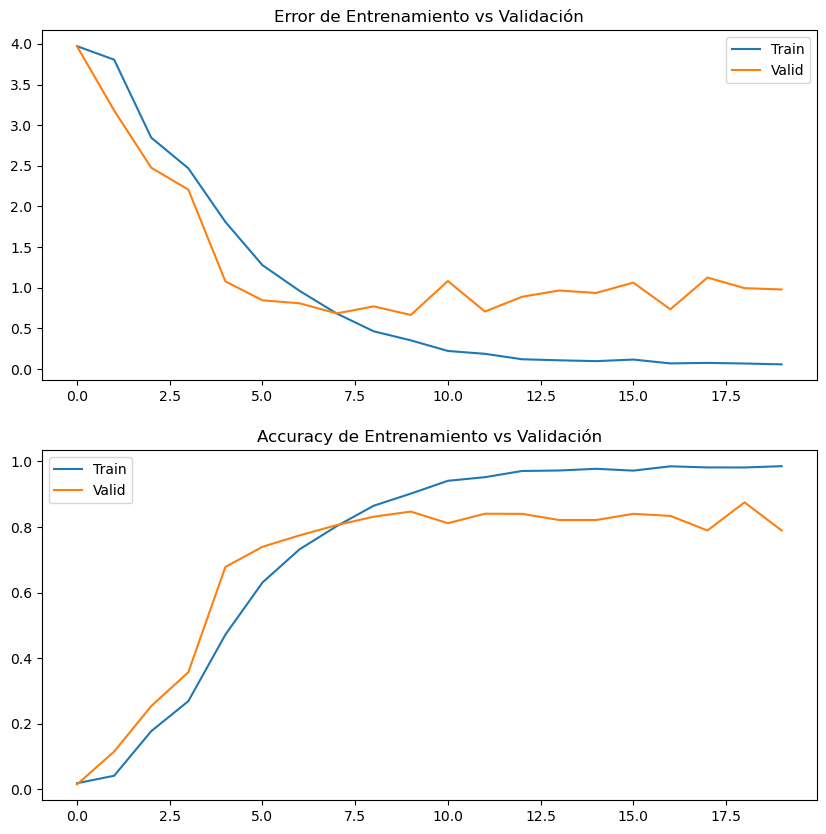

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

La performance anda parecido a Restet 50. Con algún sobreajuste

## Con Data augmentation

In [6]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.8, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='data_Cards/valid', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=64, shuffle=True)

In [ ]:
aug_vgg19_model = torchvision.models.vgg19()
last_layer_in_features = aug_vgg19_model.classifier[-1].in_features
aug_vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

aug_vgg19_optimizer = torch.optim.Adam(aug_vgg19_model.parameters(), lr=0.0001)
aug_vgg19_loss = torch.nn.CrossEntropyLoss()
aug_vgg19_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_vgg19_data = {"train": aug_train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
aug_vgg19_writer = {"train": SummaryWriter(log_dir="data_cards/aug_vgg19_train"),
                "valid": SummaryWriter(log_dir="data_cards/aug_vgg19_valid")}

aug_history = train(aug_vgg19_model,
                aug_vgg19_optimizer,
                aug_vgg19_loss,
                aug_vgg19_metric,
                aug_vgg19_data,
                20,
                aug_vgg19_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': aug_vgg19_model.state_dict(),
        'optimizer': aug_vgg19_model.state_dict(),
}
savepath='checkpoint.aug_vgg19_20'
torch.save(state,savepath)